MAE: 4.4008
RMSE: 8.7825
R²: 0.2610


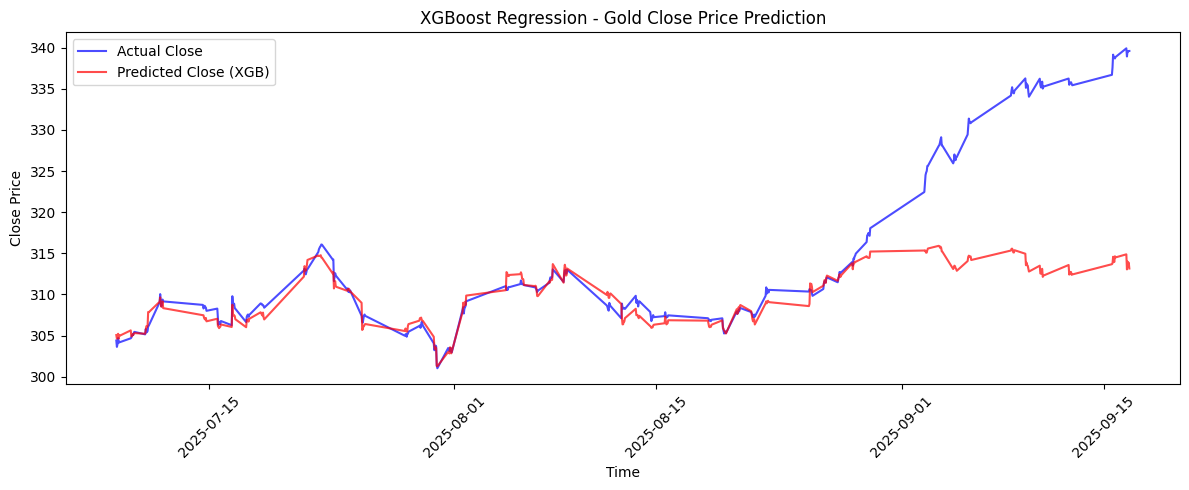

C:\Users\User\AppData\Local\Temp\ipykernel_7136\403222265.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


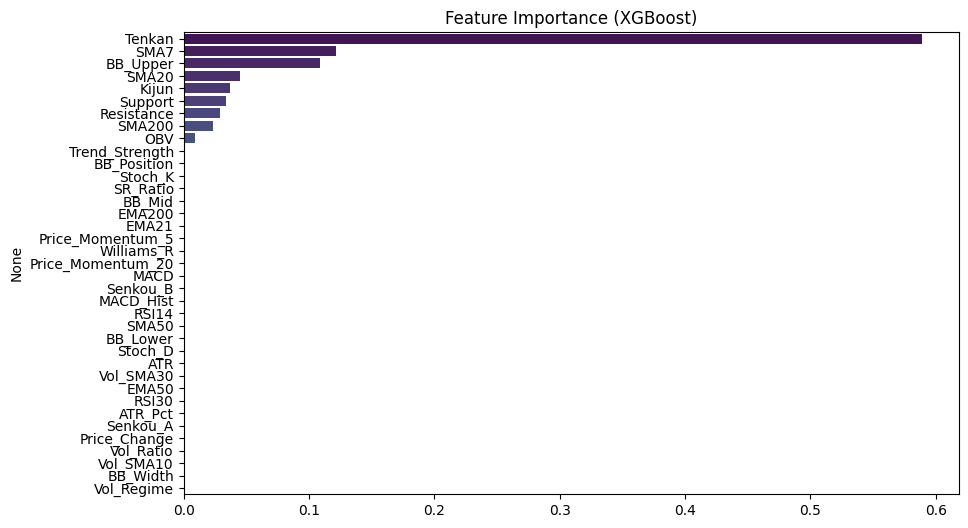

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

# 1. Load dataset
df = pd.read_csv("../dataset.csv", parse_dates=["Datetime"])

# 2. Drop NaN values
df = df.dropna()

# 3. Features & Target
X = df.drop(columns=["Datetime", "Close"])  # features (all indicators)
y = df["Close"]                             # target

# 4. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-test split (no shuffle, time series)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# 6. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# 7. Predictions
y_pred = model.predict(X_test)

# 8. Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 9. Plot actual vs predicted Close price
plt.figure(figsize=(12,5))
time_index = df["Datetime"].iloc[-len(y_test):]

plt.plot(time_index, y_test.values, label="Actual Close", color="blue", alpha=0.7)
plt.plot(time_index, y_pred, label="Predicted Close (XGB)", color="red", alpha=0.7)

plt.legend()
plt.title("XGBoost Regression - Gold Close Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Feature importance plot
plt.figure(figsize=(10,6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.show()


In [3]:
import joblib

joblib.dump(model, 'regression_model.pkl')
joblib.dump(scaler, 'regression_scaler.pkl')

['regression_scaler.pkl']

**Advanced XGBoost**

[0]	validation_0-rmse:42.70448
[1]	validation_0-rmse:40.92009
[2]	validation_0-rmse:39.29017
[3]	validation_0-rmse:37.69962
[4]	validation_0-rmse:36.17589
[5]	validation_0-rmse:34.76518
[6]	validation_0-rmse:33.39299
[7]	validation_0-rmse:32.10151
[8]	validation_0-rmse:30.86165
[9]	validation_0-rmse:29.69462
[10]	validation_0-rmse:28.57732
[11]	validation_0-rmse:27.51905
[12]	validation_0-rmse:26.51472
[13]	validation_0-rmse:25.59399
[14]	validation_0-rmse:24.69629
[15]	validation_0-rmse:23.86441
[16]	validation_0-rmse:23.06190
[17]	validation_0-rmse:22.30541
[18]	validation_0-rmse:21.57011
[19]	validation_0-rmse:20.89501
[20]	validation_0-rmse:20.23581
[21]	validation_0-rmse:19.69741
[22]	validation_0-rmse:19.12380
[23]	validation_0-rmse:18.75385
[24]	validation_0-rmse:18.41014
[25]	validation_0-rmse:17.92546
[26]	validation_0-rmse:17.46429
[27]	validation_0-rmse:17.20575
[28]	validation_0-rmse:16.94103
[29]	validation_0-rmse:16.55055
[30]	validation_0-rmse:16.20908
[31]	validation_0-

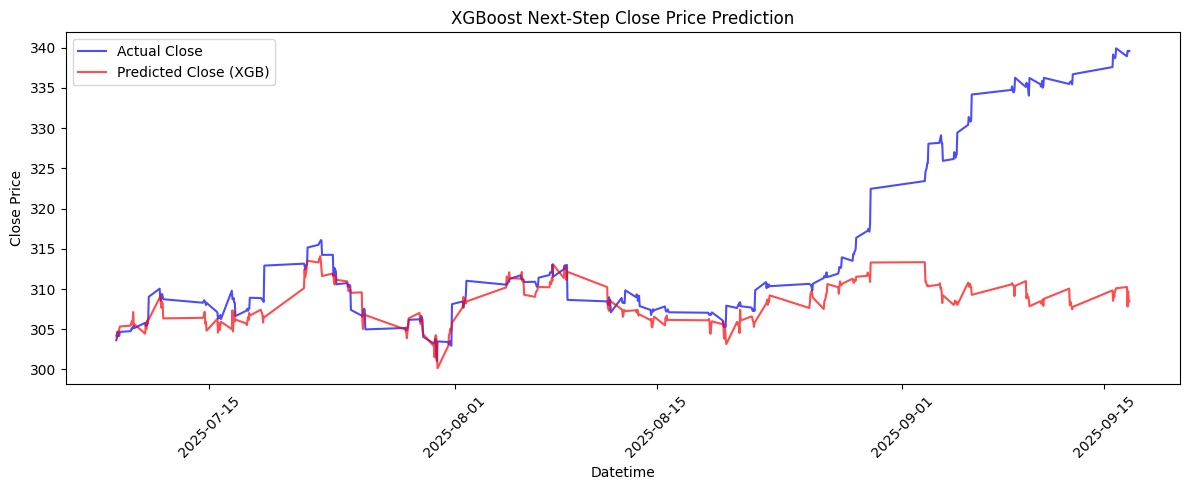

C:\Users\User\AppData\Local\Temp\ipykernel_7136\347032346.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")


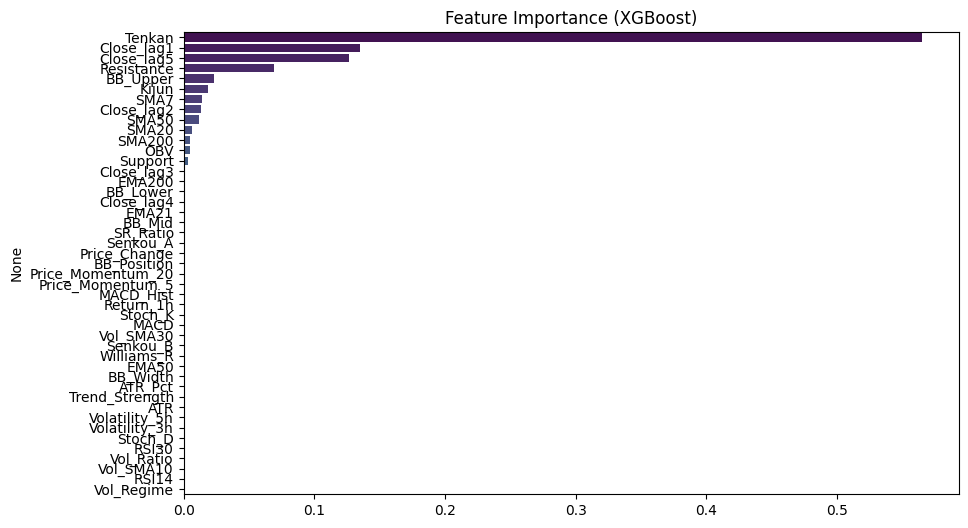

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

# 1. Load dataset
df = pd.read_csv("../dataset.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime")  # ensure chronological order

# 2. Create next-step target
df["Target_Close"] = df["Close"].shift(-1)

# 3. Lag features for Close
for lag in range(1, 6):
    df[f"Close_lag{lag}"] = df["Close"].shift(lag)

# 4. Rolling returns and volatility
df["Return_1h"] = df["Close"].pct_change()  # simple return
df["Volatility_3h"] = df["Close"].rolling(window=3).std()
df["Volatility_5h"] = df["Close"].rolling(window=5).std()

# 5. Drop NaNs created by lag/rolling
df = df.dropna()

# 6. Features & target
X = df.drop(columns=["Datetime", "Close", "Target_Close"])
y = df["Target_Close"]

# 7. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 8. Train-test split (no shuffle)
split_index = int(len(df)*0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 9. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# 10. Predictions
y_pred = model.predict(X_test)

# 11. Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 12. Plot actual vs predicted Close price
plt.figure(figsize=(12,5))
time_index = df["Datetime"].iloc[split_index:]

plt.plot(time_index, y_test.values, label="Actual Close", color="blue", alpha=0.7)
plt.plot(time_index, y_pred, label="Predicted Close (XGB)", color="red", alpha=0.7)
plt.title("XGBoost Next-Step Close Price Prediction")
plt.xlabel("Datetime")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 13. Feature importance plot
plt.figure(figsize=(10,6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.show()


**BiLSTM**

Epoch 1/200


c:\Users\User\Desktop\gold-price-prediction-indicators\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0119 - val_loss: 0.0022
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 12/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0

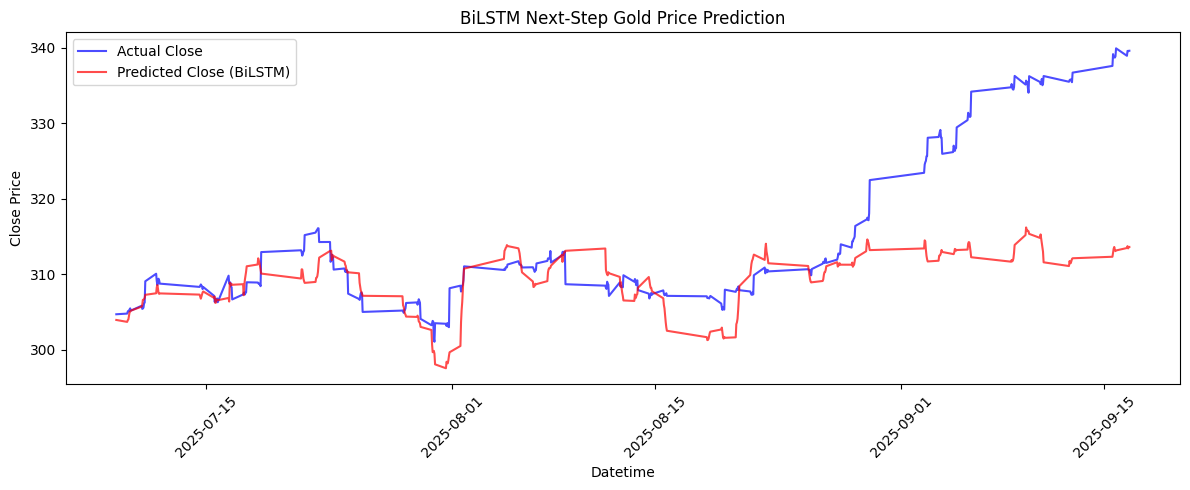

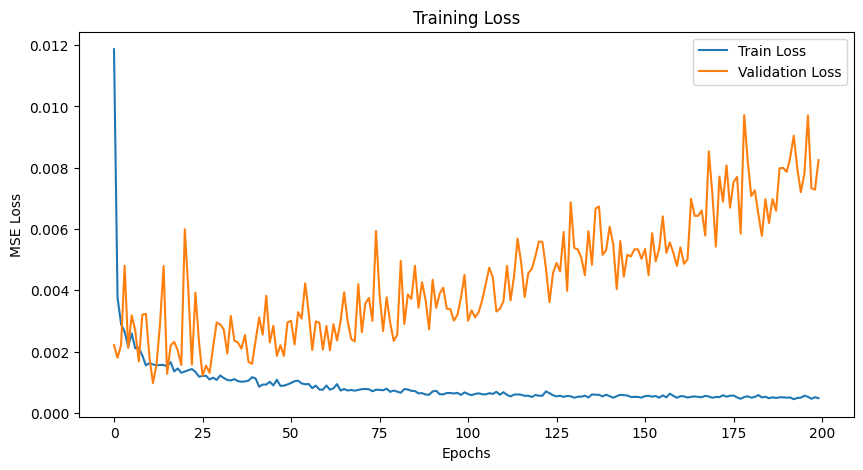

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

# 1. Load dataset
df = pd.read_csv("../dataset.csv", parse_dates=["Datetime"])
df = df.sort_values("Datetime")

# 2. Create next-step target
df["Target_Close"] = df["Close"].shift(-1)

# 3. Drop NaNs
df = df.dropna()

# 4. Select features and target
features = df.drop(columns=["Datetime", "Close", "Target_Close"])
target = df["Target_Close"].values.reshape(-1,1)

# 5. Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# 6. Scale target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(target)

# 7. Convert to sequences for LSTM
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 48  # past 24 hours
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# 8. Train-test split (80% train, 20% test)
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

# 9. Build BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(1))  # predicting next Close price

model.compile(optimizer="adam", loss="mse")

# 10. Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1
)

# 11. Predictions
y_pred_scaled = model.predict(X_test)

# 12. Inverse transform only the predictions
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# 13. Evaluation on original scale
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# 14. Plot actual vs predicted Close price
time_index = df["Datetime"].iloc[-len(y_test_orig):]

plt.figure(figsize=(12,5))
plt.plot(time_index, y_test_orig, label="Actual Close", color="blue", alpha=0.7)
plt.plot(time_index, y_pred, label="Predicted Close (BiLSTM)", color="red", alpha=0.7)
plt.title("BiLSTM Next-Step Gold Price Prediction")
plt.xlabel("Datetime")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 15. Plot training loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
